In [1]:
!pip install emot==2.1
!pip install -q wordcloud

In [2]:
import pandas as pd
import numpy as np
import wordcloud
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import string
import cv2
import requests
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
from IPython.display import Image
rcParams['figure.figsize'] = 8, 16
import urllib.request
import json
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from tqdm import tqdm
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/data_6u.csv')

In [4]:
data.head(2)

,created_utc,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,text_from_meme,text_words,url,upvote ratio,dank_level,Time_of_day
0,1.628380e+09,p040e9,0,https://i.redd.it/238mczwev0g71.jpg,0,1430077,114.0,https://b.thumbs.redditmedia.com/WBdc-Nus6faSe...,140.0,Invest in ye mudders credit card,167,{E || V] C MEetiN A!VV 1 purchased them Hsin' ...,Invest in ye mudders credit card {E || V] C ME...,/r/MemeEconomy/comments/p040e9/invest_in_ye_mu...,0.000117,0,5
1,1.628366e+09,p002qn,0,https://i.redd.it/4yacuh18qzf71.jpg,0,1430077,140.0,https://b.thumbs.redditmedia.com/avzbtegaypC3l...,140.0,Invest in bio-security,60,Mucch,Invest in bio-security Mucch,/r/MemeEconomy/comments/p002qn/invest_in_biose...,0.000042,0,4


In [5]:
data.shape

(30000, 17)

In [6]:
data.text_words[29998]

'Are you serious 🧐 When someone takes your joke seriously and starts an argument'

 ### Removing Emojis
Emojis can be indictor of some emotions that can be related to being user satisfaction. Unfortunately, we need to remove the emojis in our text analysis

In [7]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642" 
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
# remove all emojis from df
data['text_words'] = data['text_words'].apply(lambda x: remove_emoji(x)) 

In [9]:
data.text_words[29998]

'Are you serious  When someone takes your joke seriously and starts an argument'

###Remove Emoticons

In previous steps, we have removed emoji. Now, going to remove emoticons. 

***What is the difference between emoji and emoticons?***

*   :-) is an emoticon
*   😜 → emoji.

In [10]:
# Function for removing emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [11]:
data['text_words'] = data['text_words'].apply(lambda x: remove_emoticons(x))

In [12]:
data.insert(13, "processed_words", "Empty")

In [13]:
# Tokenize and lemmatize
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


def preprocess(text):
    output=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            output.append(lemmatize_stemming(token))
            
    return output

In [14]:
for ind in tqdm(data.index):     
    if data['processed_words'][ind] == 'Empty':
        words = data['text_words'][ind]
        try:
            processed_words = preprocess(words)
        except:
            processed_words = 'Fail'
        data['processed_words'][ind] = processed_words

100%|██████████| 30000/30000 [00:11<00:00, 2511.41it/s]


In [15]:
data.processed_words.sample(10)

21098    [bobby, bobby, bobby, flintstone, covid, vitam...
8512     [dumb, stupid, dumbass, ourdest, fella, clearl...
22473    [worth, source, trust, grow, orphan, immune, m...
2974     [astronomically, lmao, corbin, today, corbin, ...
29220    [swear, products, good, good, product, commerc...
19057    [premium, cheap, cunts, abouttheads, spotify, ...
7906     [flip, card, racist, cop, blackberry, elmexi_t...
15185    [make, meme, dead, template, win, join, enemy,...
5799               [me_irl, monday, friday, withuimematic]
14782    [definitely, feel, different, finally, manage,...
Name: processed_words, dtype: object

In [16]:
df = data

In [17]:
def count_stopwords(words):
    count = sum([1 for word in words if word in stop])
    return count
df['stop_words'] = df['processed_words'].apply(lambda x: count_stopwords(x))
df[['processed_words','stop_words']].values[74]


array([list(['couldn', 'mind', 'yall', 'different', 'dads', 'fanja', 'sekisf', 'rong']),
       1], dtype=object)

### Removal of Stop Words

In [18]:
#still some stopwords are present. so for this we use nltk
def remove_stopwords(words):
    x = [word for word in words if word not in stop]
    return x
data['processed_words'] = data['processed_words'].apply(lambda x: remove_stopwords(x))

In [19]:
#top 20 repeated words
words = pd.Series(data.processed_words.values)
words = words.apply(pd.Series).stack().reset_index(drop=True)
freq = words.value_counts()[:20]
freq

mematic    3422
like       2942
people     2472
time       1902
me_irl     1849
fuck       1807
know       1745
meme       1718
reddit     1477
look       1386
think      1279
post       1266
want       1256
good       1171
game       1084
go         1058
say         994
memes       890
come        868
right       866
dtype: int64

### word count

In [20]:
data['word_count'] = data['processed_words'].apply(lambda x: len(x))
data[['processed_words','word_count']].head()

,processed_words,word_count
0,"[invest, mudders, credit, card, meetin, purcha...",10
1,"[invest, security, mucch]",3
2,"[invest, jontron, slice, price, half, bargain,...",13
3,"[invest, elmo, vietnam]",3
4,"[invest, woman, statue]",3


### char count 

In [21]:
data['char_count'] = data['text_words'].str.len() ## this also includes spaces
data[['text_words','char_count']].head()

,text_words,char_count
0,Invest in ye mudders credit card {E || V] C ME...,101
1,Invest in bio-security Mucch,28
2,INVEST in Jontron slicing the price in half! A...,135
3,Invest in Elmo in Vietnam,26
4,Invest in woman with her statue,32


### Number of words in processed words at Dank level

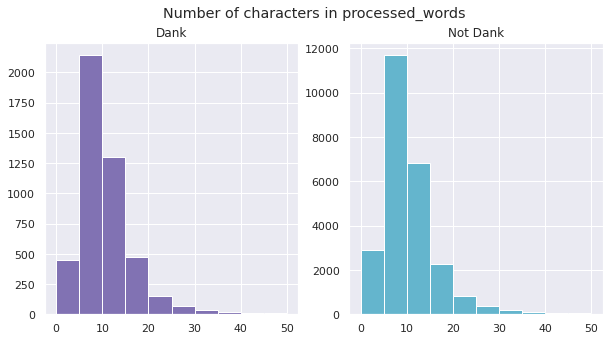

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

#dank
text_len = data.loc[data['dank_level']==1]['processed_words'].str.len()
axs[0].hist(text_len, color='m', range=(0,50))
axs[0].set_title('Dank')

#not dank
text_len = data.loc[data['dank_level']==0]['processed_words'].str.len()
axs[1].hist(text_len, color='c',range=(0,50))
axs[1].set_title('Not Dank')
fig.suptitle('Number of characters in processed_words')

plt.show()

### Number of Characters in text at dank level

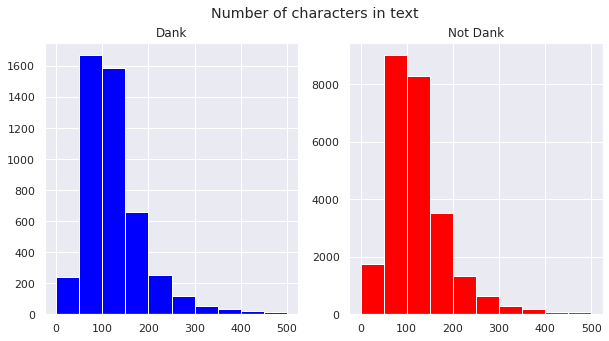

In [23]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

#dank
text_len = data.loc[data['dank_level']==1]['text_words'].str.len()
axs[0].hist(text_len, color='blue', range=(0,500))
axs[0].set_title('Dank')

#not dank
text_len = data.loc[data['dank_level']==0]['text_words'].str.len()
axs[1].hist(text_len, color='red',range=(0,500))
axs[1].set_title('Not Dank')
fig.suptitle('Number of characters in text')

plt.show()

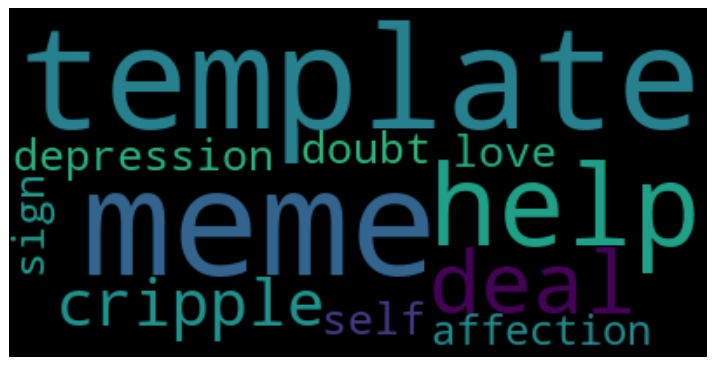

In [24]:
abc = data.processed_words[55]
abc = " ".join(x for x in abc)
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(abc)

# Display the generated image:
plt.figure(figsize= (10,10), dpi= 90)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#Word cloud for the all reviews
text_for_cloud = " ".join(x for words in data.processed_words for x in words)
print ("There are {} words in the combination of all reviews.".format(len(text_for_cloud)))

There are 2069609 words in the combination of all reviews.


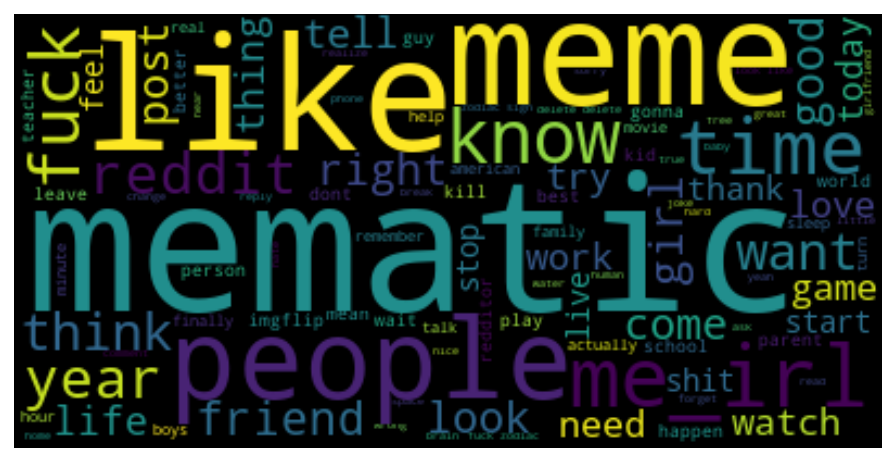

In [26]:
# Create stopword list:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="black", max_words= 100).generate(text_for_cloud)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize= (8,8), dpi= 140)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
data.to_csv('/content/drive/MyDrive/case_study_2/input/data_7.csv',index=False)